# 이제까지 만들었던 모델을 튜닝하고 배포하기!

CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout

## 모델 고정해서 사용하기
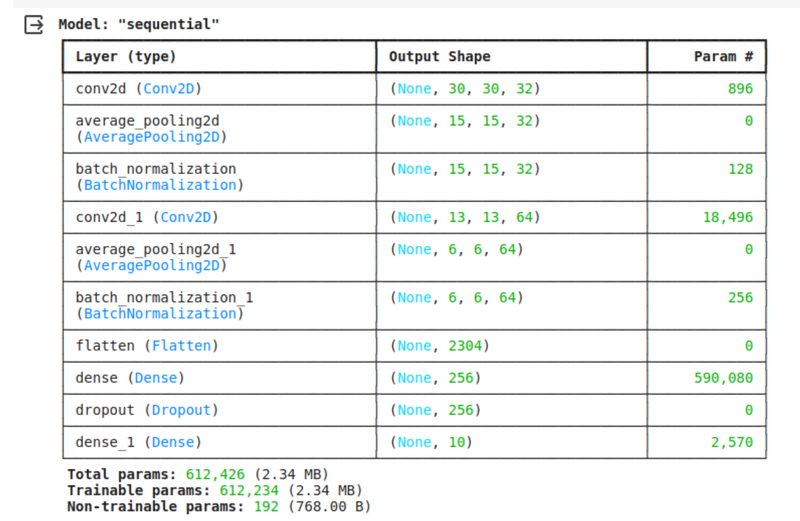

### CIFAR-10 모델을 만드는 함수 정의

In [2]:
def create_cifar10_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=input_shape),
        AveragePooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'),
        AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

### 모델 생성

In [3]:
model = create_cifar10_model()

### 모델 컴파일

In [4]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 모델 요약 출력

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

## Data Centric AI 맛보기

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

### CIFAR-10 데이터셋 불러오기

In [31]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#### CIFAR-10 클래스 이름

In [32]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

### 특정 ID에 대한 데이터를 시각화하는 함수

In [33]:
def visualize_image(index, x_data, y_data, classes):
    plt.imshow(x_data[index])
    plt.title(f"Given label: {classes[int(y_data[index][0])] if y_data[index].size > 0 else 'Unknown'}")
    plt.show()

In [34]:
def visualize_images(indices, x_data, y_data, classes, title_prefix="Corrected "):
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 11, i + 1)
        plt.imshow(x_data[index])
        label = classes[int(y_data[index][0])] if y_data[index].size > 0 else 'Unknown'
        plt.title(f"{title_prefix}ID: {index}\nLabel: {label}")
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

#### 데이터 시각화

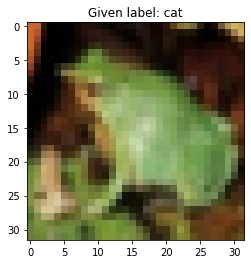

In [35]:
visualize_image(2405, x_test, y_test, class_names)

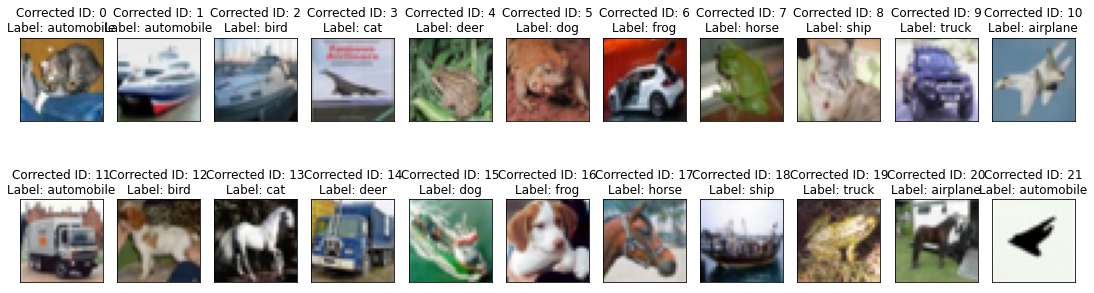

In [38]:
incorrect_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

visualize_images(incorrect_indices, x_test, y_test, class_names)

### 잘못된 레이블을 수정하는 과정
labelerrors.com에서 제공하는 정보를 바탕으로 레이블 수정

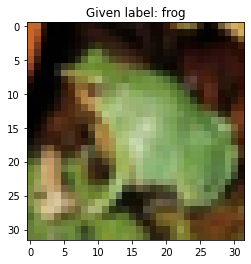

In [13]:
y_test[2405] = 6
visualize_image(2405, x_test, y_test, class_names)

In [39]:
print(y_test[0])

[1]


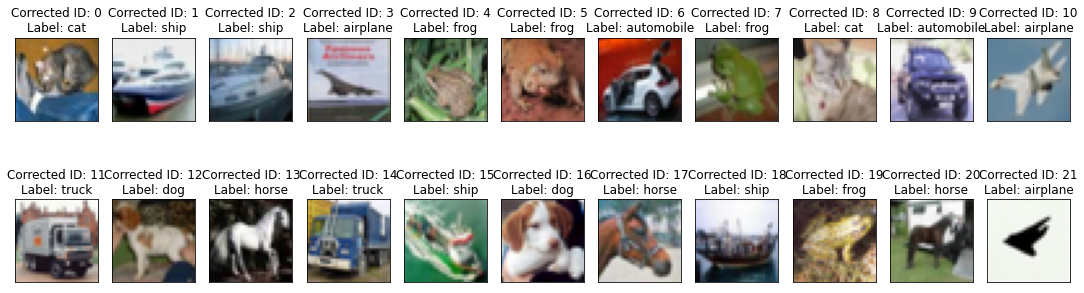

In [36]:
incorrect_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
# correct_labels = [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1]

# 레이블 수정
# for idx, correct_label in zip(incorrect_indices, correct_labels):
#     y_test[idx] = correct_label

# 수정된 레이블 데이터 시각화
visualize_images(incorrect_indices, x_test, y_test, class_names)

## 하이퍼파라미터 튜닝
위에 있는 모델을 기반으로 KerasTuner로 하이퍼파라미터 튜닝을 진행한다.  
튜닝한 하이퍼 파라미터로 학습을 진행하고 모델을 SavedModel 형식으로 저장한다.

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar10
from kerastuner.tuners import RandomSearch

/tmp/ipykernel_2877/1122957290.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


### 데이터 전처리

In [41]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f'X train shape: {x_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {x_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (50000, 32, 32, 3)
y train shape: (50000, 10)
X test shape: (10000, 32, 32, 3)
y test shape: (10000, 10)


In [42]:
y_train_original = tf.keras.utils.to_categorical(y_train, 10)
y_test_original = tf.keras.utils.to_categorical(y_test, 10)

# 수정된 레이블 데이터의 형태 확인
print(f'y_train_original shape: {y_train_original.shape}')
print(f'y_test_original shape: {y_test_original.shape}')

y_train_original shape: (50000, 10, 10)
y_test_original shape: (10000, 10, 10)


In [43]:
def create_cifar10_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(32, 32, 3),
                     padding='valid'))
    model.add(AveragePooling2D())
    model.add(BatchNormalization())
    
    model.add(Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=64, step=32),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu',
                     padding='valid'))
    model.add(AveragePooling2D())
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=256, max_value=512, step=256), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Keras Tuner 설정

In [44]:
tuner = RandomSearch(
    create_cifar10_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='output',
    project_name='CIFAR10_tuning'
)

Reloading Tuner from output/CIFAR10_tuning/tuner0.json


### 튜닝을 시작하기 전에 검증 데이터셋 준비

In [45]:
from sklearn.model_selection import train_test_split
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=0.1)

### Keras Tuner 실행

In [47]:
tuner.search(x_train_split, y_train_split,
             epochs=30,
             validation_data=(x_val_split, y_val_split),
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

#### 최적의 하이퍼파라미터 결과 확인

In [48]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

#### 최적의 모델 가져오기

In [49]:
best_model = tuner.get_best_models(num_models=1)[0]

### 모델 평가

In [50]:
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f'테스트 데이터셋에 대한 손실: {loss}, 정확도: {accuracy}')

313/313 [==============================] - 3s 3ms/step - loss: 1.2774 - accuracy: 0.5706
테스트 데이터셋에 대한 손실: 1.2773796319961548, 정확도: 0.5705999732017517


### 모델 저장

In [51]:
best_model.save('best_model.h5')

## TFLite

In [52]:
import os
print(os.getcwd())

/aiffel/aiffel/mlops


In [53]:
# 모델 로드
model = tf.keras.models.load_model('/aiffel/aiffel/mlops/best_model.h5')

# TFLite 변환기 생성
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 모델 변환
tflite_model = converter.convert()

# TFLite 모델 저장
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3cj8pag0/assets


```bash
tensorflow_model_server --port=8500 \
                        --rest_api_port=8501 \
                        --model_name=best_model \
                        --model_base_path=/Users/project/aiffel/mlops/best_model
                        
docker run -p 8501:8501 \            
    --mount type=bind,source=/Users/project/aiffel/mlops/best_model, target=/models/best_model \
    -e MODEL_NAME=best_model \                   
    -t tensorflow/serving                                                       
```

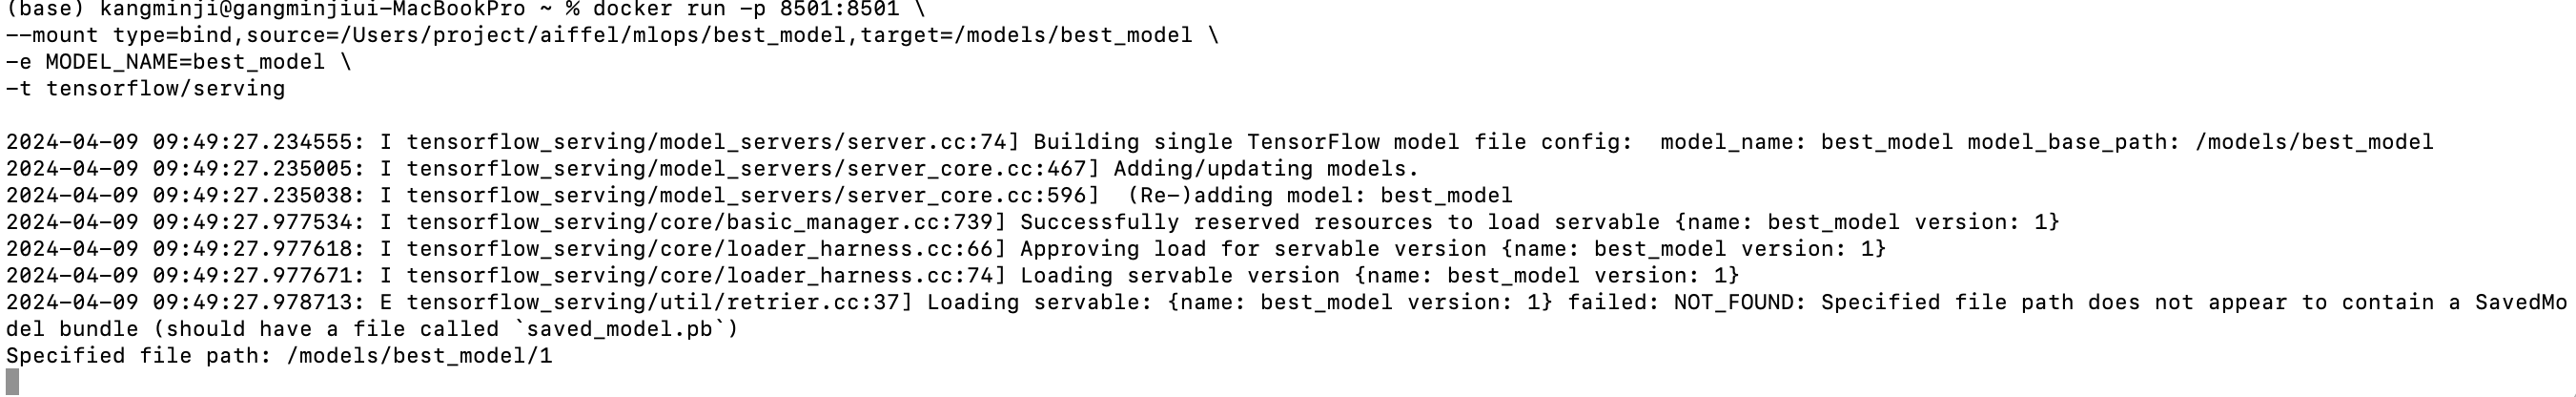